# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

**Библиотеки**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pylab
import seaborn as sns
import numpy as np
from numpy.random import RandomState
import scipy.stats as st

import scipy.stats as stats

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error

import warnings

warnings.filterwarnings("ignore")

**Методы**

In [2]:
# проверка пропусков и дубликатов
def check_nan_duplicates(df):
    print((df.isna().sum() / len(df)) * 100, '\n')
    print('---------------- \n')
    print('Проверка на явные дубликаты: ')
    print(f'Кол-во явных дубликатов: {df.duplicated().sum()} \n')
    print('---------------- \n')
    print('Проверка на не явные дубликаты: ')
    cols = df.select_dtypes(include='object').columns.to_list()
    cols = cols.remove('id')
    if cols == None:
        print('Категориальных переменных нет, кроме id')
    else:
        for i in cols:
            print(i, df[i].unique(), '\n')
    print('---------------- \n')
    df.info()
    
# построение графиков
def plot_(df):
    num_cols = df.select_dtypes(exclude='object').columns.to_list()
    
    fig, ax = plt.subplots(nrows=len(num_cols), ncols=1)
    plt.subplots_adjust(hspace=0.8)
    k = 0
    for i in num_cols:
                df.plot(y=i, 
                        kind='hist', 
                        grid=True, 
                        figsize=(10,15),  
                        title=i, 
                        ax=ax[k],  
                       )
                ax[k].set_xlabel(i)
                ax[k].set_ylabel('Частота')
                k += 1

    fig, ax = plt.subplots(nrows=len(num_cols), ncols=1, figsize=(10,30))
    plt.subplots_adjust(hspace=0.8)
    k = 0
    for i in num_cols:
            ax[k].set_title(i)
            ax[k].boxplot(df[i])
            plt.xlabel('')
            k+=1
    None

#Масштабирование данных
def data_scaling(X_train, X_test):
    scaler = StandardScaler()
    
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, X_test

# прогноз объем скважины
def predict_inventory_volume(X, y):
    RANDOM_STATE = 42
    TEST_SIZE = 0.25
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE, test_size=TEST_SIZE)
    
    X_train, X_test = data_scaling(X_train, X_test)
    
    model = LinearRegression()
    
    model.fit(X_train, y_train)
    
    pred = model.predict(X_test)

    print(f'RMSE на тестовой выборке {round(np.sqrt(mean_squared_error(pred, y_test)), 2)}')
    return pred, y_test

# Расчёт прибыли по выбранным скважинам
def profit_calculation(y_pred, y_test, best_points, revenue_unit_barrel, budget):
    y_pred_sorted = y_pred.sort_values(ascending=False)[:best_points]
    result = y_test[y_pred_sorted.index]
    return result.sum() * revenue_unit_barrel - budget
    

## Загрузка и подготовка данных

### Загрузка данных 

***Геологоразведка 1-го региона***

In [3]:
geo_data_0 = pd.read_csv('/datasets/geo_data_0.csv')
print(geo_data_0.info())
geo_data_0.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


#### Вывод

1) Название столбцов имеют одинаковый стиль 

2) В данном DataFrame отсутвуют пропуски

3) В признаках не нужно изменять тип данных

***Геологоразведка 2-го региона***

In [4]:
geo_data_1 = pd.read_csv('/datasets/geo_data_1.csv')
print(geo_data_1.info())
geo_data_1.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


#### Вывод

1) Название столбцов имеют одинаковый стиль 

2) В данном DataFrame отсутвуют пропуски

3) В признаках не нужно изменять тип данных

***Геологоразведка 3-го региона***

In [5]:
geo_data_2 = pd.read_csv('/datasets/geo_data_2.csv')
print(geo_data_2.info())
geo_data_2.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


#### Вывод

1) Название столбцов имеют одинаковый стиль 

2) В данном DataFrame отсутвуют пропуски

3) В признаках не нужно изменять тип данных

### Предобработка данных

***Геологоразведка 1-го региона***

In [6]:
check_nan_duplicates(geo_data_0)

id         0.0
f0         0.0
f1         0.0
f2         0.0
product    0.0
dtype: float64 

---------------- 

Проверка на явные дубликаты: 
Кол-во явных дубликатов: 0 

---------------- 

Проверка на не явные дубликаты: 
Категориальных переменных нет, кроме id
---------------- 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


#### Вывод

1) Явных дубликатов в данном DataFrame нет

2) Не явных дубликатов в данном DataFrame нет

3) Пропусков в данном DataFrame нет

***Геологоразведка 2-го региона***

In [7]:
check_nan_duplicates(geo_data_1)

id         0.0
f0         0.0
f1         0.0
f2         0.0
product    0.0
dtype: float64 

---------------- 

Проверка на явные дубликаты: 
Кол-во явных дубликатов: 0 

---------------- 

Проверка на не явные дубликаты: 
Категориальных переменных нет, кроме id
---------------- 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


#### Вывод

1) Явных дубликатов в данном DataFrame нет

2) Не явных дубликатов в данном DataFrame нет

3) Пропусков в данном DataFrame нет

***Геологоразведка 3-го региона***

In [8]:
check_nan_duplicates(geo_data_2)

id         0.0
f0         0.0
f1         0.0
f2         0.0
product    0.0
dtype: float64 

---------------- 

Проверка на явные дубликаты: 
Кол-во явных дубликатов: 0 

---------------- 

Проверка на не явные дубликаты: 
Категориальных переменных нет, кроме id
---------------- 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


#### Вывод

1) Явных дубликатов в данном DataFrame нет

2) Не явных дубликатов в данном DataFrame нет

3) Пропусков в данном DataFrame нет

### Исследовательский анализ 

***Геологоразведка 1-го региона***

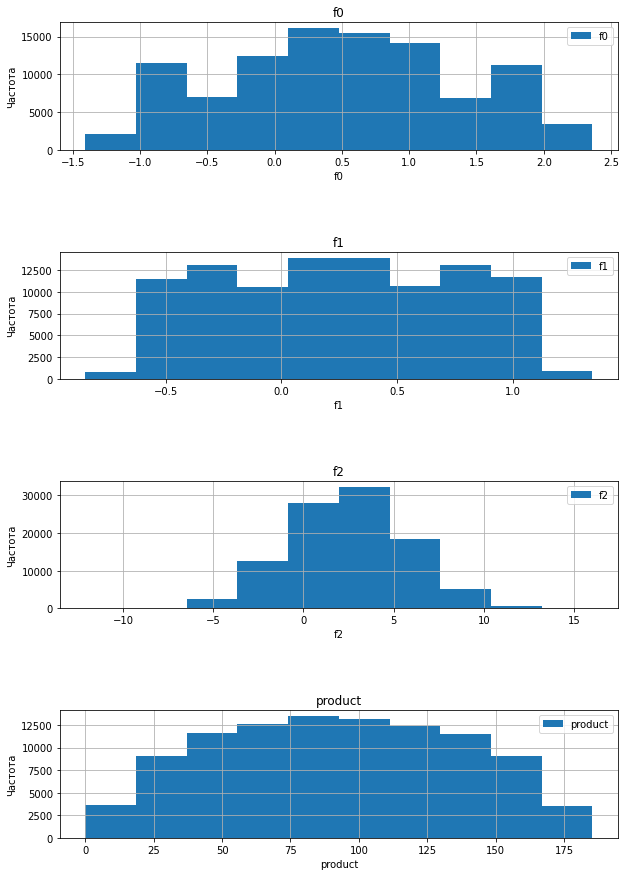

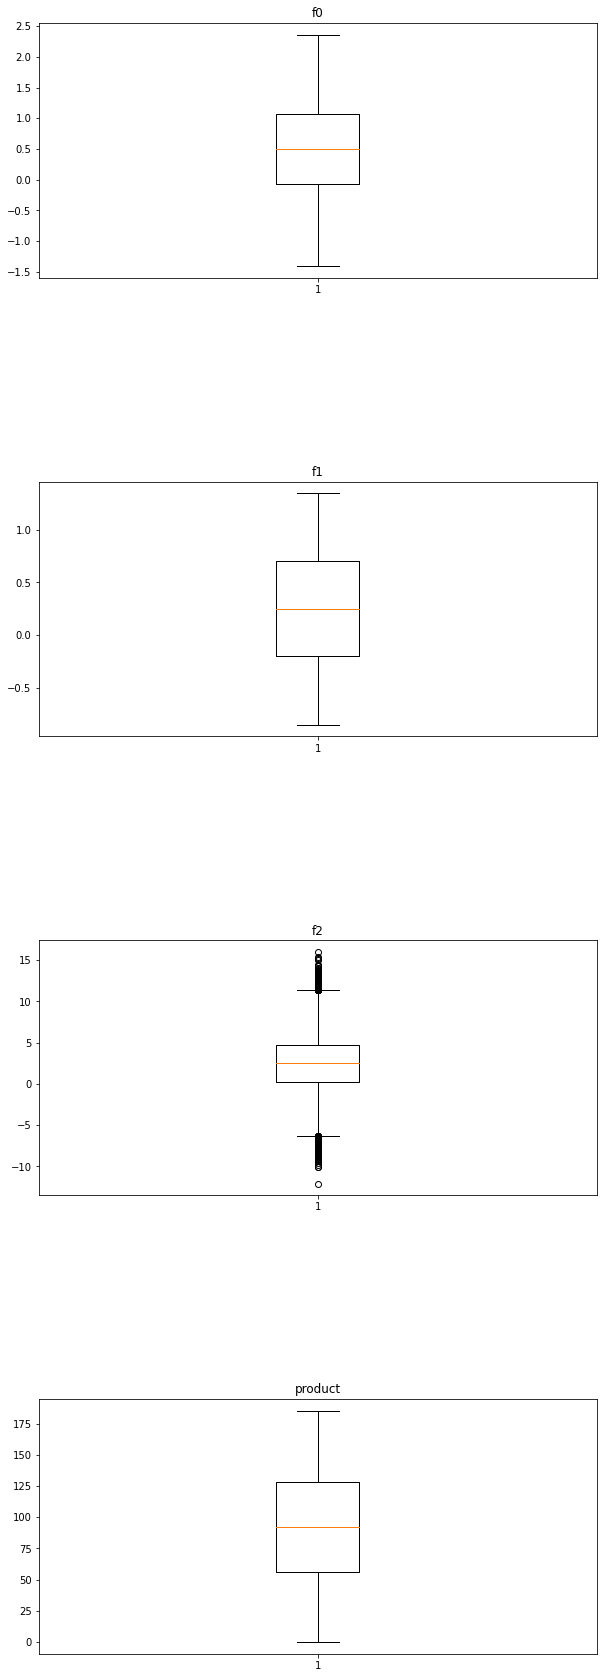

In [9]:
plot_(geo_data_0)

**Обработка выбросов**

#### Вывод

Признак *f2* имеет выбросы, но мы их оставим для разнообразия признака

**Проверить количественные признаки на нормальное распределние**

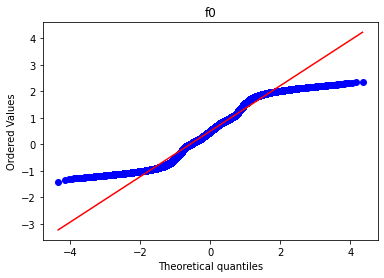

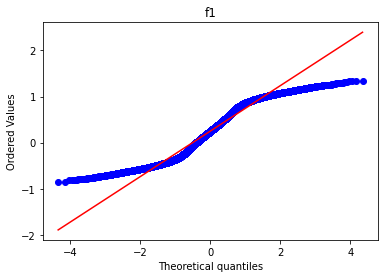

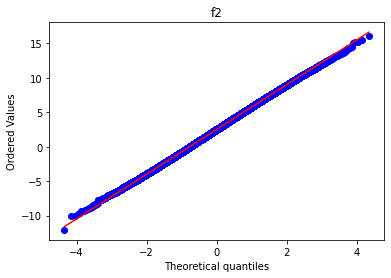

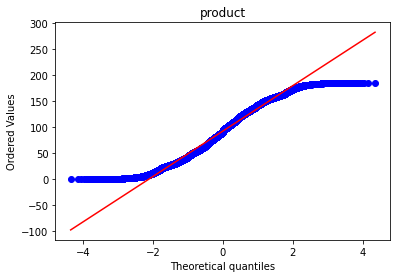

In [10]:
num_cols = geo_data_0.select_dtypes(exclude='object').columns.to_list()
for i in num_cols:
        stats.probplot(geo_data_0[i], dist='norm', plot=pylab)
        plt.title(i)
        pylab.show()

#### Вывод

Все признаки имеют нормальное распределение

***Геологоразведка 2-го региона***

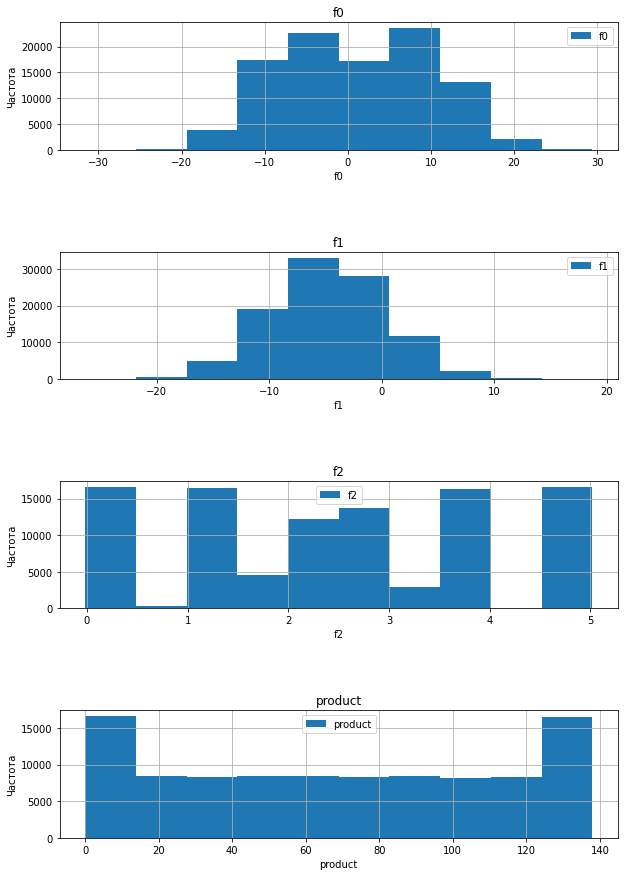

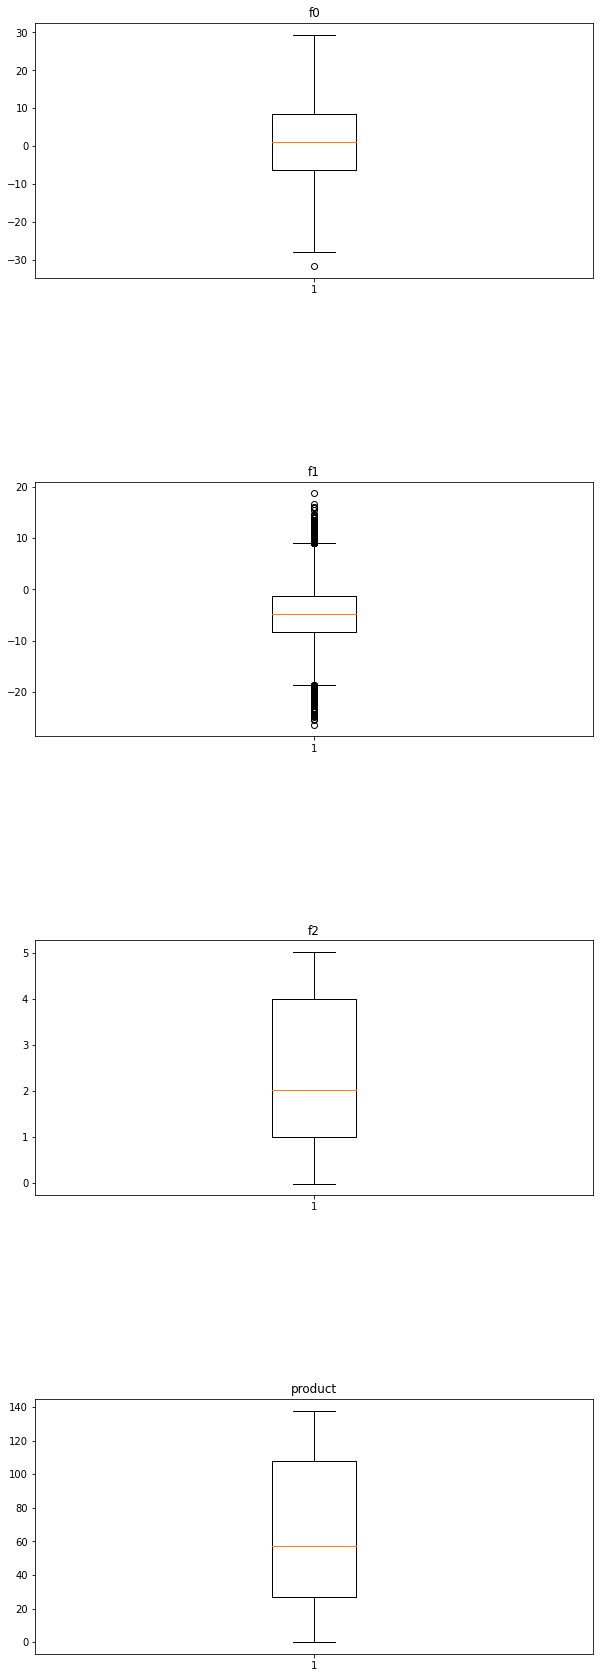

In [11]:
plot_(geo_data_1)

**Обработка выбросов**

#### Вывод

Признак *f0* имеет выбросы, но мы их оставим для разнообразия признака

Признак *f1* имеет выбросы, но мы их оставим для разнообразия признака

**Проверить количественные признаки на нормальное распределние**

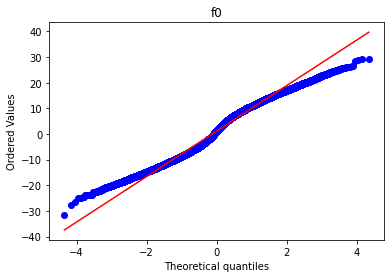

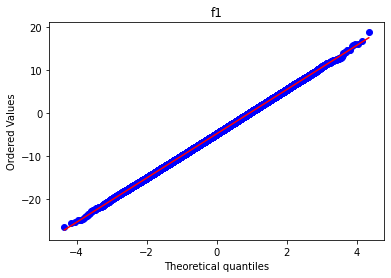

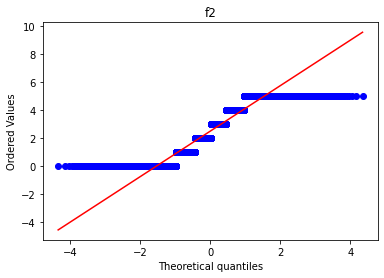

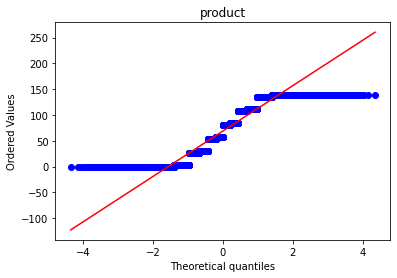

In [12]:
num_cols = geo_data_1.select_dtypes(exclude='object').columns.to_list()
for i in num_cols:
        stats.probplot(geo_data_1[i], dist='norm', plot=pylab)
        plt.title(i)
        pylab.show()

#### Вывод

Все признаки имеют нормальное распределение

***Геологоразведка 3-го региона***

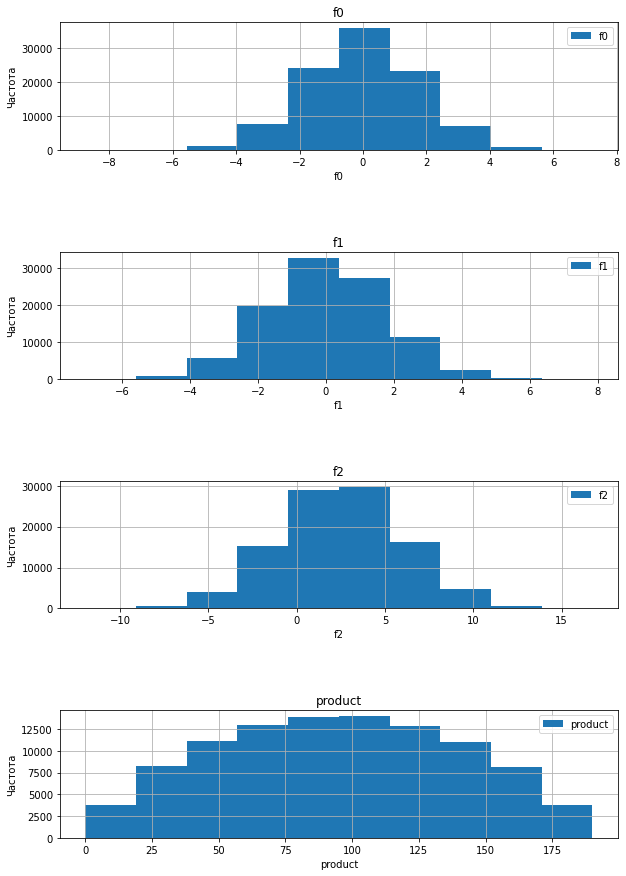

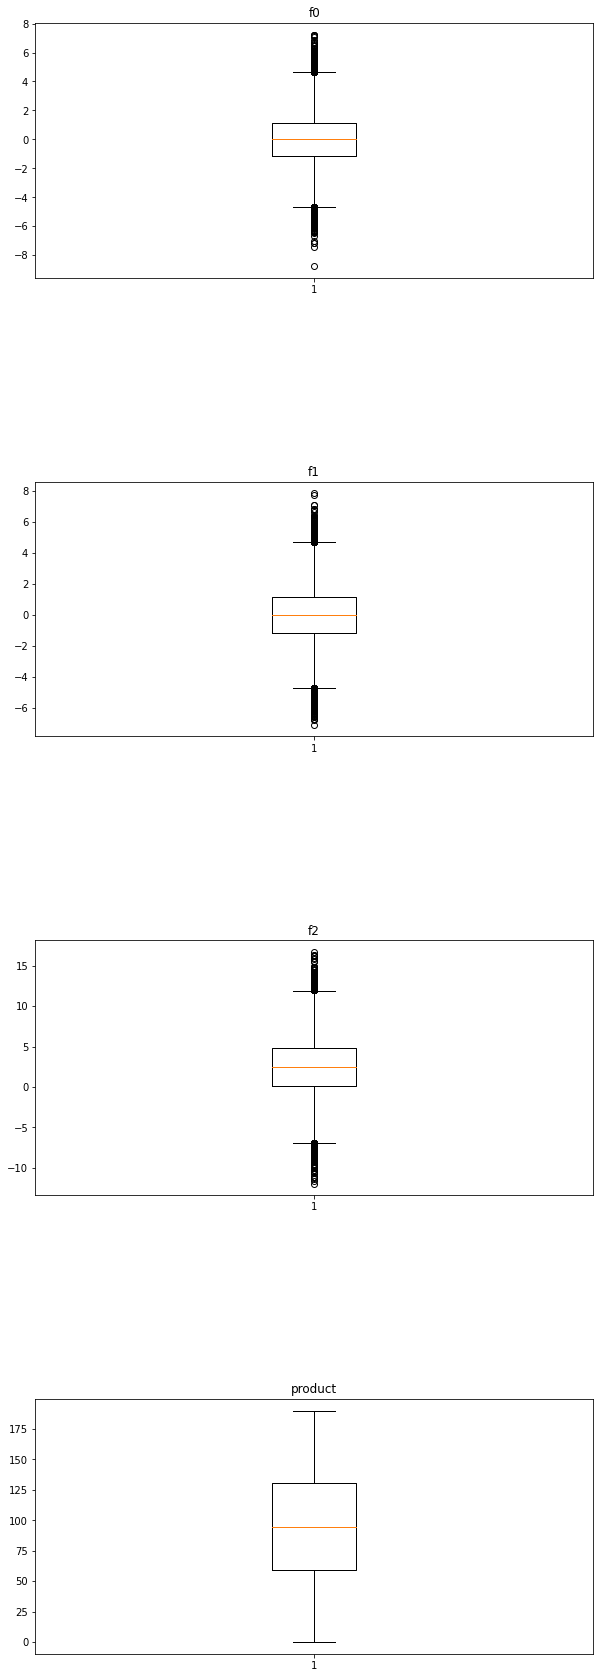

In [13]:
plot_(geo_data_2)

**Обработка выбросов**

#### Вывод

Признак *f0* имеет выбросы, но мы их оставим для разнообразия признака

Признак *f1* имеет выбросы, но мы их оставим для разнообразия признака

Признак *f2* имеет выбросы, но мы их оставим для разнообразия признака

**Проверить количественные признаки на нормальное распределние**

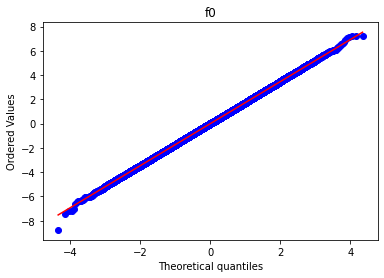

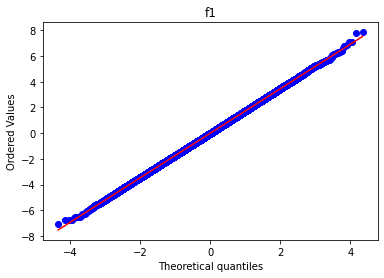

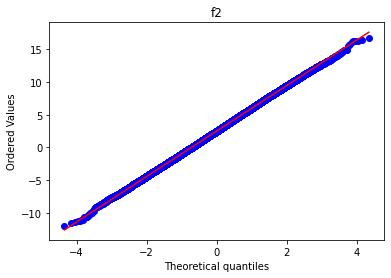

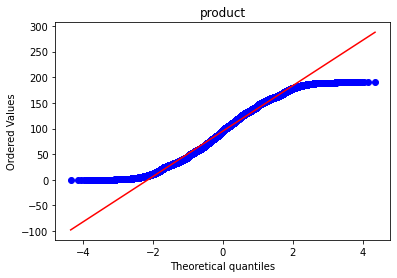

In [14]:
num_cols = geo_data_2.select_dtypes(exclude='object').columns.to_list()
for i in num_cols:
        stats.probplot(geo_data_2[i], dist='norm', plot=pylab)
        plt.title(i)
        pylab.show()

#### Вывод

Все признаки имеют нормальное распределение

### Корреляционный анализ

***Геологоразведка 1-го региона***

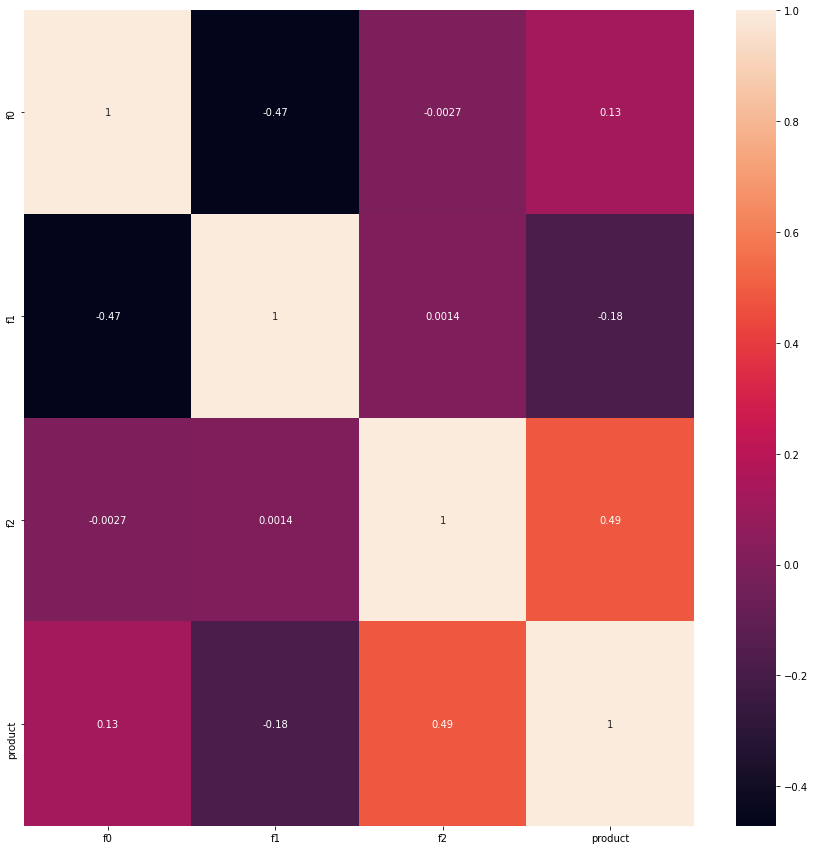

In [15]:
num_cols = geo_data_0.select_dtypes(exclude='object').columns.to_list()

corr = geo_data_0[num_cols].corr(method = 'spearman')
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(corr, annot = True)
None

#### Вывод

1) *f0* имеет слабую линейную зависимость с таргетом

2) *f1* не имеет линейную зависимость с таргетом 

3) *f2* имеет умеренную линейную зависимость с таргетом

4) Мультиколлинеарность отсутвует 

***Геологоразведка 2-го региона***

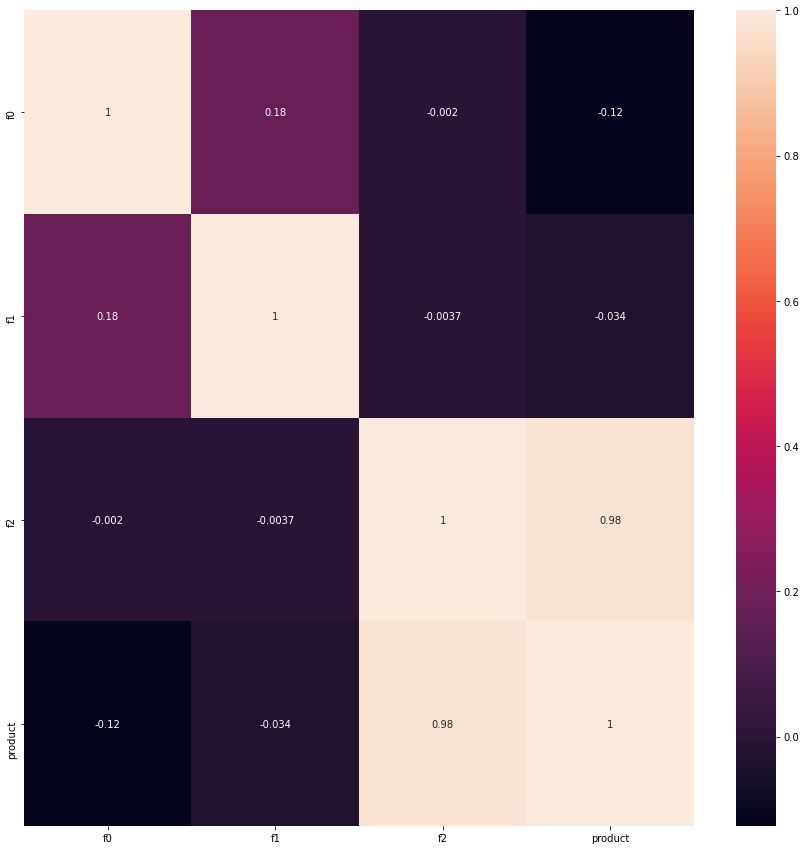

In [16]:
num_cols = geo_data_1.select_dtypes(exclude='object').columns.to_list()

corr = geo_data_1[num_cols].corr(method = 'spearman')
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(corr, annot = True)
None

#### Вывод

1) *f0* не имеет линейную зависимость с таргетом

2) *f1* не имеет линейную зависимость с таргетом 

3) *f2* имеет весьма высокую линейную зависимость с таргетом

4) Мультиколлинеарность отсутвует 

***Геологоразведка 3-го региона***

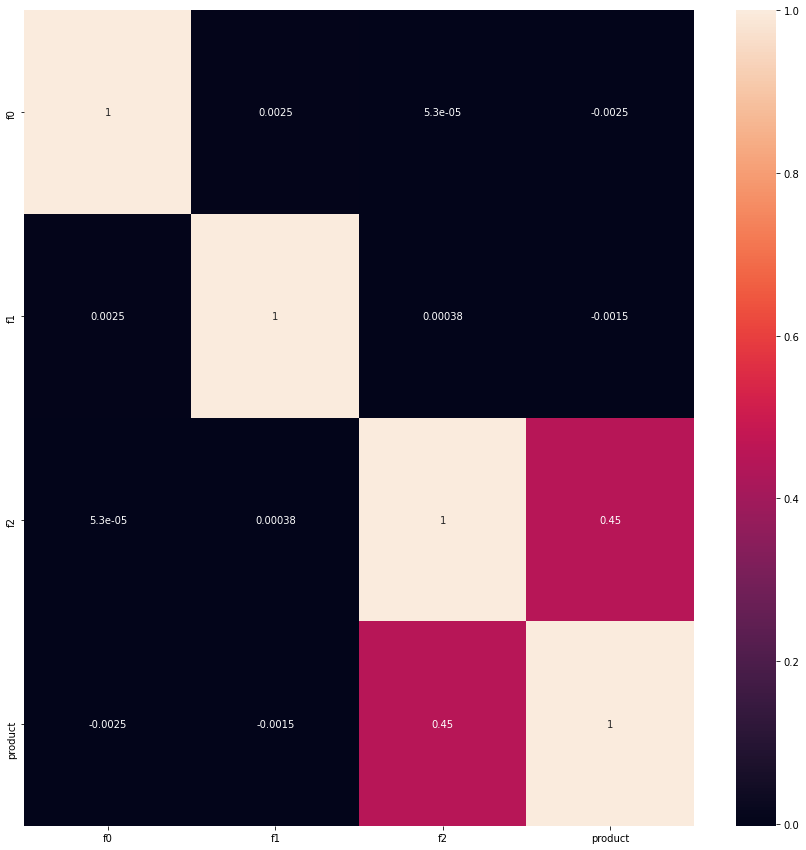

In [17]:
num_cols = geo_data_2.select_dtypes(exclude='object').columns.to_list()

corr = geo_data_2[num_cols].corr(method = 'spearman')
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(corr, annot = True)
None

#### Вывод

1) *f0* не имеет линейную зависимость с таргетом

2) *f1* не имеет линейную зависимость с таргетом 

3) *f2* имеет умеренную линейную зависимость с таргетом

4) Мультиколлинеарность отсутвует 

## Обучение и проверка модели

***Геологоразведка 1-го региона***

In [18]:
y_pred_0 , y_true_0 = predict_inventory_volume(geo_data_0[['f0', 'f1', 'f2']], geo_data_0['product'])
y_mean_0 = round(y_pred_0.mean(),2)
print(f'Средний запас предсказанного сырья 1-го региона: {y_mean_0}')

RMSE на тестовой выборке 37.76
Средний запас предсказанного сырья 1-го региона: 92.4


***Геологоразведка 2-го региона***

In [19]:
y_pred_1 , y_true_1 = predict_inventory_volume(geo_data_1[['f0', 'f1', 'f2']], geo_data_1['product'])
y_mean_1 = round(y_pred_1.mean(),2)
print(f'Средний запас предсказанного сырья 2-го региона: {y_mean_1}')

RMSE на тестовой выборке 0.89
Средний запас предсказанного сырья 2-го региона: 68.71


***Геологоразведка 3-го региона***

In [20]:
y_pred_2 , y_true_2 = predict_inventory_volume(geo_data_2[['f0', 'f1', 'f2']], geo_data_2['product'])
y_mean_2 = round(y_pred_2.mean(),2)
print(f'Средний запас предсказанного сырья 3-го региона: {y_mean_2}')

RMSE на тестовой выборке 40.15
Средний запас предсказанного сырья 3-го региона: 94.77


#### Вывод

***Геологоразведка 1-го региона***

1) Модель которая была обучена на данных 1-го региона показала метрику RMSE равную 37.76

2) Средний запас предсказанного сырья 1-го региона равняется 92.4

***Геологоразведка 2-го региона***

1) Модель которая была обучена на данных 2-го региона показала метрику RMSE равную 0.89. Метрика показала такое маленькое значение, возможно, из-за высокой корелляции признака *f2* с таргетом

2) Средний запас предсказанного сырья 2-го региона равняется 68.71. Он является самым наименьшим по сравнению с другими регионами

***Геологоразведка 3-го региона***

1) Модель которая была обучена на данных 3-го региона показала метрику RMSE равную 40.15

2) Средний запас предсказанного сырья 3-го региона равняется 94.77

## Подготовка к расчёту прибыли

**Ключевые значения для расчётов:**

In [21]:
number_points = 500
best_points = 200
budget = 10000000000
revenue_unit_barrel = 450000
volume = 1000

In [22]:
sufficient_volume_for_well_development = round((budget / revenue_unit_barrel / best_points),2)
print(f'Достаточный объём сырья для безубыточной разработки новой скважины: {sufficient_volume_for_well_development}')

Достаточный объём сырья для безубыточной разработки новой скважины: 111.11


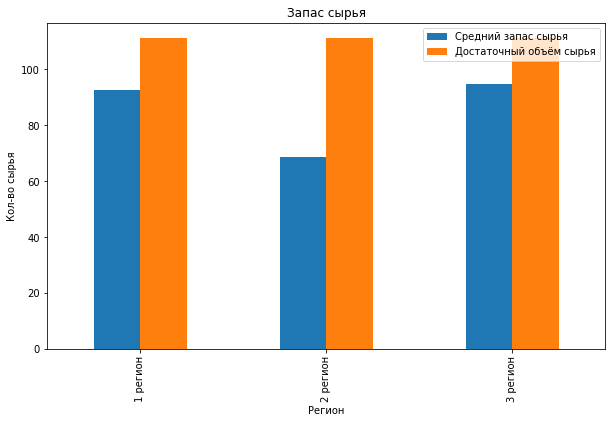

In [23]:
region = ['1 регион', '2 регион', '3 регион']
mean = [y_mean_0, y_mean_1, y_mean_2]
const = [sufficient_volume_for_well_development, sufficient_volume_for_well_development, sufficient_volume_for_well_development]

df = pd.DataFrame({'Средний запас сырья': mean, 'Достаточный объём сырья': const, 'Регион': region})
df[['Регион', 'Средний запас сырья', 'Достаточный объём сырья']].plot(x='Регион', kind='bar', figsize=(10,6), ylabel='Кол-во сырья', title='Запас сырья')
None

#### Вывод

1) Средний запас у всех регионов меньше чем объём сырья для безубыточной разработки новой скважины.

2) Нужно из всех регионов выбрать 200 точек для скважин и вкладываться в их строительство  

## Расчёт прибыли и рисков 

In [24]:
y_pred = [y_pred_0, y_pred_1, y_pred_2]
y_true = [y_true_0, y_true_1, y_true_2]
for i in range (len(y_pred)):
    y_pred[i] = pd.Series(y_pred[i])
    y_true[i] = y_true[i].reset_index(drop=True)
profit_best_200 = []

for i in range(len(y_pred)):
    profit_best_200.append(profit_calculation(y_pred[i], y_true[i], best_points, revenue_unit_barrel, budget))
profit_best_200 = pd.Series(profit_best_200, name='прибыль')
profit_best_200.index = region
pd.DataFrame(profit_best_200)

,прибыль
1 регион,3.359141e+09
2 регион,2.415087e+09
3 регион,2.598572e+09


#### Вывод

1) В первом регионе 200 лучших скважин больше всего прибыли принесет: 3359141000 руб

2) Во втором и третьем регионе 200 лучших скважин меньше принесут прибыли: 2415087000 руб, 2598572000 руб

In [25]:
state = RandomState(12345)
info_region = pd.DataFrame(columns=['Регион', 'Средняя прибыль','95%-й доверительный интервал','Риск убытков'])
for i in range(len(region)):
    profit = []
    pred = y_pred[i]
    true = y_true[i]
    for j in range(volume):
        true_sample = true.sample(number_points, random_state=state, replace = True)
        pred_sample = pred[true_sample.index]
        
        profit.append(profit_calculation(pred_sample, true_sample, best_points, revenue_unit_barrel, budget))
    profit = pd.Series(profit)

    mean = profit.mean()
    region_i = region[i]
    #confidential_interval = st.t.interval(alpha=0.95, df=len(profit)-1, loc=np.mean(profit), scale=st.sem(profit))
    confidential_interval = profit.quantile(0.025), profit.quantile(0.975)
    risks = round(((profit < 0).sum() / profit.count() * 100),1)
    info_region.loc[len(info_region)] = [region_i, mean, confidential_interval, risks]
info_region

,Регион,Средняя прибыль,95%-й доверительный интервал,Риск убытков
0,1 регион,6.150470e+08,"(-20884982.29624209, 1239730575.9180634)",3.0
1,2 регион,6.470977e+08,"(143797589.38681215, 1202909913.330936)",0.3
2,3 регион,6.011183e+08,"(-18054437.17901816, 1289954719.1920974)",3.1


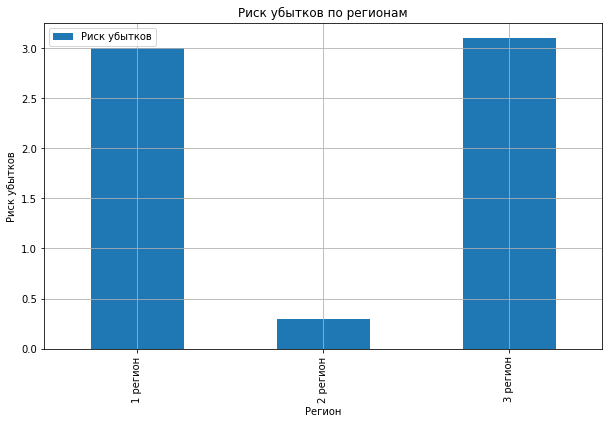

In [26]:
info_region[['Регион', 'Риск убытков',]].plot(x='Регион', kind='bar', figsize=(10,6), ylabel='Риск убытков', title='Риск убытков по регионам', grid=True)
None

#### Вывод

1) Только во втором регионе риск убытков меньше 2.5%

2) Средняя прибыль больше всего во втором регионе 

3) Только у второго региона доверительный интервал не содержить отрицательных чисел

**Для разработки скважин нам подойдет второй регион, так как только там риск убытков меньше 2.5% и Средняя прибыль больше всего во втором регионе**

## Общие выводы

### Предобработка данных

***Геологоразведка 1-го региона***

1) Явных дубликатов в данном DataFrame нет

2) Не явных дубликатов в данном DataFrame нет

3) Пропусков в данном DataFrame нет

***Геологоразведка 2-го региона***

1) Явных дубликатов в данном DataFrame нет

2) Не явных дубликатов в данном DataFrame нет

3) Пропусков в данном DataFrame нет

***Геологоразведка 3-го региона***

1) Явных дубликатов в данном DataFrame нет

2) Не явных дубликатов в данном DataFrame нет

3) Пропусков в данном DataFrame нет

----

### Исследовательский анализ 

***Геологоразведка 1-го региона***

1) Признак *f2* имеет выбросы, но мы их оставим для разнообразия признака

2) Все признаки имеют нормальное распределение

***Геологоразведка 2-го региона***

1) Признак *f0* имеет выбросы, но мы их оставим для разнообразия признака

2) Признак *f1* имеет выбросы, но мы их оставим для разнообразия признака

3) Все признаки имеют нормальное распределение

***Геологоразведка 3-го региона***

1) Признак *f0* имеет выбросы, но мы их оставим для разнообразия признака

2) Признак *f1* имеет выбросы, но мы их оставим для разнообразия признака

3) Признак *f2* имеет выбросы, но мы их оставим для разнообразия признака

4) Все признаки имеют нормальное распределение

----

### Корреляционный анализ 

***Геологоразведка 1-го региона***

1) *f0* имеет слабую линейную зависимость с таргетом

2) *f1* не имеет линейную зависимость с таргетом 

3) *f2* имеет умеренную линейную зависимость с таргетом

4) Мультиколлинеарность отсутвует 

***Геологоразведка 2-го региона***

1) *f0* не имеет линейную зависимость с таргетом

2) *f1* не имеет линейную зависимость с таргетом 

3) *f2* имеет весьма высокую линейную зависимость с таргетом

4) Мультиколлинеарность отсутвует 

***Геологоразведка 3-го региона***

1) *f0* не имеет линейную зависимость с таргетом

2) *f1* не имеет линейную зависимость с таргетом 

3) *f2* имеет умеренную линейную зависимость с таргетом

4) Мультиколлинеарность отсутвует 

----

### Обучение и проверка модели

***Геологоразведка 1-го региона***

1) Модель которая была обучена на данных 1-го региона показала метрику RMSE равную 37.76

2) Средний запас предсказанного сырья 1-го региона равняется 92.4

***Геологоразведка 2-го региона***

1) Модель которая была обучена на данных 2-го региона показала метрику RMSE равную 0.89. Метрика показала такое маленькое значение, возможно, из-за высокой корелляции признака *f2* с таргетом

2) Средний запас предсказанного сырья 2-го региона равняется 68.71. Он является самым наименьшим по сравнению с другими регионами

***Геологоразведка 3-го региона***

1) Модель которая была обучена на данных 3-го региона показала метрику RMSE равную 40.15

2) Средний запас предсказанного сырья 3-го региона равняется 94.77

----

### Подготовка к расчёту прибыли

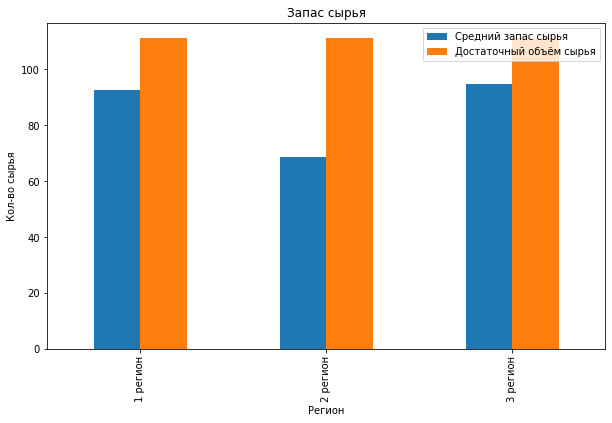

1) Средний запас у всех регионов меньше чем объём сырья для безубыточной разработки новой скважины.

2) Нужно из всех регионов выбрать 200 точек для скважин и вкладываться в их строительство  

----

### Расчёт прибыли и рисков 

| Регион      | Прибыль        |
|-------------|----------------|
| 1 регион    | 3.359141e+09   | 
| 2 регион    | 2.415087e+09   |
| 3 регион    | 2.598572e+09   |

1) В первом регионе 200 лучших скважин больше всего прибыли принесет: 3359141000 руб

2) Во втором и третьем регионе 200 лучших скважин меньше принесут прибыли: 2415087000 руб, 2598572000 руб

| Регион      | Средняя прибыль| 95%-й доверительный интервал             | Риск убытков|
|-------------|----------------|------------------------------------------|-------------|
| 1 регион    | 6.150470e+08   | (-20884982.29624209, 1239730575.9180634) | 3.0         |
| 2 регион    | 6.470977e+08   | (143797589.38681215, 1202909913.330936)  | 0.3         |
| 3 регион    | 6.011183e+08   | (-18054437.17901816, 1289954719.1920974) | 3.1         |

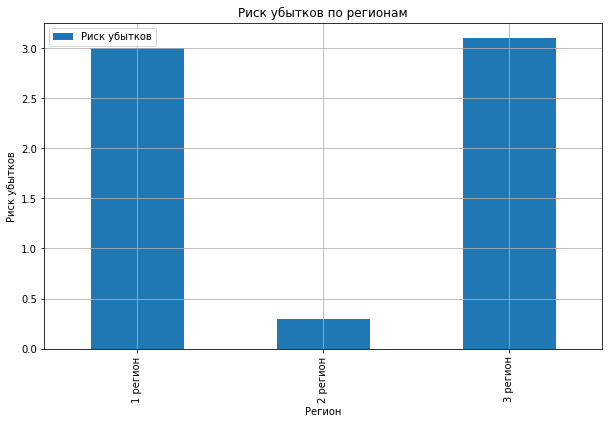

1) Только во втором регионе риск убытков меньше 2.5%

2) Средняя прибыль больше всего во втором регионе 

3) Только у второго региона доверительный интервал не содержить отрицательных чисел

**Для разработки скважин нам подойдет второй регион, так как только там риск убытков меньше 2.5% и Средняя прибыль больше всего во втором регионе**